In [1]:
from convokit import Corpus, download
import pandas as pd

In [2]:
from pathlib import Path

corpus_path = Path.home() / ".convokit" / "saved-corpora" / "subreddit-AskScienceFiction"
corpus = Corpus(filename=str(corpus_path))

In [3]:
conv_rows = []
for conv in corpus.iter_conversations():
    conv_rows.append({
        "conversation_id": conv.id,

        # Conversation-level info
        "conv_title": conv.meta.get("title"),
        "conv_num_comments": conv.meta.get("num_comments"),
        "conv_domain": conv.meta.get("domain"),
        "conv_subreddit": conv.meta.get("subreddit"),
        "conv_gilded": conv.meta.get("gilded"),
        "conv_gildings": conv.meta.get("gildings"),
        "conv_stickied": conv.meta.get("stickied"),
        "conv_author_flair_text": conv.meta.get("author_flair_text"),
    })

conv_df = pd.DataFrame(conv_rows).drop_duplicates(subset=["conversation_id"])

# ---- Utterance rows ----
utt_rows = []
for utt in corpus.iter_utterances():
    utt_rows.append({
        # Utterance-level required fields
        "id": utt.id,
        "speaker": utt.speaker.id if utt.speaker else None,
        "conversation_id": utt.conversation_id,
        "reply_to": utt.reply_to,
        "timestamp": utt.timestamp,
        "text": utt.text,

        # Utterance-level metadata
        "utt_score": utt.meta.get("score"),
        "utt_top_level_comment": utt.meta.get("top_level_comment"),
        "utt_retrieved_on": utt.meta.get("retrieved_on"),
        "utt_gilded": utt.meta.get("gilded"),
        "utt_gildings": utt.meta.get("gildings"),
        "utt_stickied": utt.meta.get("stickied"),
        "utt_permalink": utt.meta.get("permalink"),
        "utt_author_flair_text": utt.meta.get("author_flair_text"),
    })

utt_df = pd.DataFrame(utt_rows)

# ---- Join utterances with conversation metadata ----
df = utt_df.merge(conv_df, on="conversation_id", how="left")

df["created_datetime"] = pd.to_datetime(df["timestamp"], unit="s", errors="coerce")
# Post vs comment: in this corpus, top_level_comment is None for the post itself
df["is_post"] = df["utt_top_level_comment"].isna()

df["corpus_subreddits"] = ",".join(sorted(map(str, corpus.meta.get("subreddit", []))))
df["corpus_num_posts"] = corpus.meta.get("num_posts")
df["corpus_num_comments"] = corpus.meta.get("num_comments")
df["corpus_num_speaker"] = corpus.meta.get("num_speaker")


In [4]:
df.columns

Index(['id', 'speaker', 'conversation_id', 'reply_to', 'timestamp', 'text',
       'utt_score', 'utt_top_level_comment', 'utt_retrieved_on', 'utt_gilded',
       'utt_gildings', 'utt_stickied', 'utt_permalink',
       'utt_author_flair_text', 'conv_title', 'conv_num_comments',
       'conv_domain', 'conv_subreddit', 'conv_gilded', 'conv_gildings',
       'conv_stickied', 'conv_author_flair_text', 'created_datetime',
       'is_post', 'corpus_subreddits', 'corpus_num_posts',
       'corpus_num_comments', 'corpus_num_speaker'],
      dtype='object')

In [5]:
posts = df[df["is_post"]].copy()
print(posts.shape)

(85745, 28)


In [6]:
print("Min date:", posts["created_datetime"].min())
print("Max date:", posts["created_datetime"].max())

Min date: 2011-07-01 16:02:04
Max date: 2018-10-31 23:44:56


In [115]:
posts["year"] = posts["created_datetime"].dt.year
df["year"] = df["created_datetime"].dt.year
posts['title_len'] = posts['conv_title'].str.len()
posts['hour'] = posts['created_datetime'].dt.hour
posts['day_of_week'] = posts['created_datetime'].dt.dayofweek


posts['has_question_mark'] = posts['conv_title'].str.contains(r'\?', na=False).astype(int)

posts.to_parquet("posts.parquet", index=False)

In [8]:
posts["year"].value_counts()
df["year"].value_counts()
posts.groupby(['has_question_mark']).size()

has_question_mark
0     8731
1    77014
dtype: int64

In [9]:
posts.columns

Index(['id', 'speaker', 'conversation_id', 'reply_to', 'timestamp', 'text',
       'utt_score', 'utt_top_level_comment', 'utt_retrieved_on', 'utt_gilded',
       'utt_gildings', 'utt_stickied', 'utt_permalink',
       'utt_author_flair_text', 'conv_title', 'conv_num_comments',
       'conv_domain', 'conv_subreddit', 'conv_gilded', 'conv_gildings',
       'conv_stickied', 'conv_author_flair_text', 'created_datetime',
       'is_post', 'corpus_subreddits', 'corpus_num_posts',
       'corpus_num_comments', 'corpus_num_speaker', 'year', 'title_len',
       'hour', 'day_of_week', 'has_question_mark'],
      dtype='object')

# Plan

Time travel to 2017 and use it as "live data"

# Thresholds

Separate into "past" data 2011-2016 and current, 2017
Get the top 10% by score based on past data only to prevent future leak

In [10]:
past_posts_df = posts[posts["created_datetime"].dt.year <= 2016].copy()
threshold = past_posts_df["utt_score"].quantile(0.90)
posts["is_popular"] = (posts["utt_score"] >= threshold).astype(int)


In [11]:
posts.groupby(posts["created_datetime"].dt.year)["is_popular"].mean()


created_datetime
2011    0.000000
2012    0.023288
2013    0.039200
2014    0.080842
2015    0.112171
2016    0.124225
2017    0.130137
2018    0.107982
Name: is_popular, dtype: float64

In [12]:
train_mask = posts["created_datetime"].dt.year <= 2016
posts.loc[train_mask, "is_popular"].mean()


np.float64(0.10124044113310661)

# Model

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import re

df = posts.copy()
df = df.dropna(subset=["conv_title", "is_popular", "created_datetime"])
df["conv_title"] = df["conv_title"].astype(str)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['title_len_log'] = np.log1p(df['title_len'])



def extract_tag(title):
    match = re.search(r'\[(.*?)\]', title)
    return match.group(1).lower() if match else "no_tag"

df['universe_tag'] = df['conv_title'].apply(extract_tag)

In [116]:
past = df[df["created_datetime"].dt.year <= 2016].copy()
live_2017 = df[df["created_datetime"].dt.year == 2017].copy()

print("Past (<=2016):", past.shape)
print("Live (2017):  ", live_2017.shape)

past.to_parquet("posts-to-2016.parquet", index=False)
live_2017.to_parquet("posts-2017.parquet", index=False)

Past (<=2016): (50869, 38)
Live (2017):   (19003, 38)


In [93]:
X_past = past[['conv_title','title_len', "universe_tag",'hour', 'day_of_week', "title_len_log", "hour_sin", "hour_cos",'has_question_mark','conv_author_flair_text']]
y_past = past["is_popular"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X_past, y_past,
    test_size=0.2,
    random_state=42,
    stratify=y_past
)
print(type(X_train), X_train.shape) 

<class 'pandas.core.frame.DataFrame'> (40695, 10)


In [106]:
text_col = "conv_title"

#num_cols = ["title_len_log", "hour_sin", "hour_cos", "day_of_week", "has_question_mark"]
num_cols = ["day_of_week", "has_question_mark", "hour_sin", "title_len_log","hour_cos"]

cat_cols = ["conv_author_flair_text", "universe_tag"]

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            lowercase=True,
            stop_words="english",
            min_df=5,
            max_features=15000,
            ngram_range=(1, 2),
            analyzer='word'
        ), text_col),
        
        ("char", TfidfVectorizer(
            analyzer='char_wb',
            ngram_range=(3, 5), 
            max_features=5000
        ), text_col),

        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler(with_mean=False))  
        ]), num_cols),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

In [107]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=15000,
                                                                  min_df=5,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'conv_title'),
                                                 ('char',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  max_features=5000,
                                                                  ngram_range=(3,
                                                                               5)),
                                                  'conv_title'),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['day_of_week',
                                                   'has_question_mark',
                                                   'hour_sin', 'title_len_log',
                                                   'hour_cos']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['conv_author_flair_text',
                                                   'universe_tag'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [108]:
# from lightgbm import LGBMClassifier

# # Tree models don't strictly require scaling, but it doesn't hurt.
# # They are excellent for imbalanced data via scale_pos_weight.
# model = Pipeline(steps=[
#     ("preprocess", preprocess),
#     ("clf", LGBMClassifier(
#         n_estimators=500,
#         learning_rate=0.05,
#         num_leaves=31,
#         class_weight='balanced', # Handles the 10% imbalance
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

# model.fit(X_train, y_train)

# Evaluation

In [109]:
val_proba = model.predict_proba(X_val)[:, 1]
print("=== Validation (<=2016) ===")
print("ROC-AUC:", roc_auc_score(y_val, val_proba))
print("PR-AUC:", average_precision_score(y_val, val_proba))

=== Validation (<=2016) ===
ROC-AUC: 0.7160924665970152
PR-AUC: 0.22108215240002846


In [110]:
from sklearn.metrics import precision_score, recall_score

# Get probabilities
val_proba = model.predict_proba(X_val)[:, 1]

custom_threshold = 0.96 
preds_custom = (val_proba >= custom_threshold).astype(int)

print(f"Threshold: {custom_threshold}")
print("Precision:", precision_score(y_val, preds_custom))
print("Recall:", recall_score(y_val, preds_custom))

Threshold: 0.96
Precision: 0.4375
Recall: 0.006796116504854369


Best Threshold for F1-Score: 0.9884
Max F1-Score: nan


/var/folders/93/5jfg7fbd127_8q18v4r3f3bh0000gp/T/ipykernel_99890/558532314.py:10: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


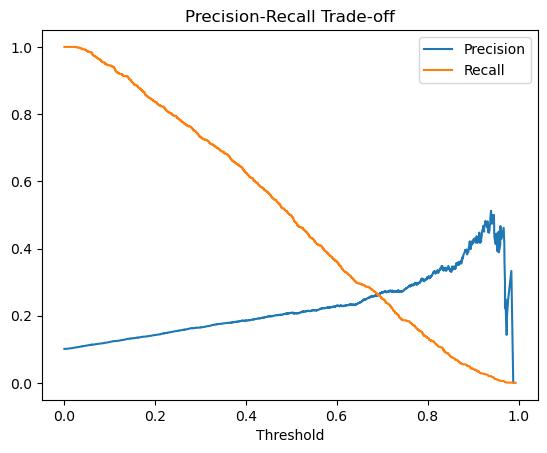

In [111]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities
val_proba = model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)

# Calculate F1 score for each threshold
# F1 = 2 * (precision * recall) / (precision + recall)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold for F1-Score: {best_threshold:.4f}")
print(f"Max F1-Score: {f1_scores[best_idx]:.4f}")

# Plotting the trade-off
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.title("Precision-Recall Trade-off")
plt.legend()
plt.savefig("pr_tradeoff.png")

# Live data (test)

In [113]:
X_live = live_2017[['conv_title', 'hour', 'day_of_week','has_question_mark','conv_author_flair_text',"universe_tag","title_len_log", "hour_sin","hour_cos"]]
# X_live = live_2017[['conv_title','title_len', 'hour', 'day_of_week', "title_len_log", "hour_sin", "hour_cos",'has_question_mark','conv_author_flair_text']]

y_live = live_2017["is_popular"].astype(int)

live_proba = model.predict_proba(X_live)[:, 1]
print("\n=== Live (2017) ===")
print("ROC-AUC:", roc_auc_score(y_live, live_proba))
print("PR-AUC:", average_precision_score(y_live, live_proba))


=== Live (2017) ===
ROC-AUC: 0.6947692061560681
PR-AUC: 0.26232461837443255


# Looking at data

In [40]:
feature_names = model.named_steps["preprocess"].get_feature_names_out()
coefs = model.named_steps["clf"].coef_[0]

feat_df = (
    pd.DataFrame({
        "feature": feature_names,
        "weight": coefs
    })
    .sort_values("weight", ascending=False)
)

In [41]:
feat_df.head(20)

,feature,weight
11528,text__moderation,3.398751
11298,text__meta,3.240926
15747,text__single,3.005886
7121,text__futurama,2.930006
12657,text__papers,2.827548
15111,text__sauron,2.817548
10868,text__marvel life,2.743003
11628,text__moria,2.728005
8536,text__hobbit,2.602254
9624,text__joker,2.592408


In [42]:
feat_df.tail(20)

,feature,weight
2756,text__changed,-1.699278
8429,text__heroes,-1.740591
5829,text__ending,-1.761704
11315,text__metal gear,-1.764838
13156,text__plot,-1.786323
15997,text__sonic,-1.813535
3816,text__darkness,-1.826035
1511,text__bane,-1.831020
9560,text__jesus,-1.850325
16654,text__stronger,-1.871738


In [43]:
posts[posts["conv_title"].str.contains(r"\bjesus\b", case=False, na=False)] \
     [["conv_title", "is_popular", "utt_score"]] \
     .head(10)

,conv_title,is_popular,utt_score
106,"[Bible] When Jesus resurrected, did the flesh/...",0,52
302,[South Park] If God and Jesus appear multiple ...,0,46
909,[Cars] How would a car Jesus die for the sins ...,0,9
1118,[DC] Has Jesus Christ actually make an appeara...,0,18
1570,[The Passion of the Christ] How is Jesus' suff...,0,16
1797,[Futurama] Farnsworth said that there was a se...,0,17
3821,"[Indiana Jones] What if Jesus opened the Ark, ...",0,21
3889,[Easter Bunny] Why is there a magical rabbit d...,0,23
4151,[Marvel] Was Jesus a mutant and if so where wo...,0,7
4738,"[Stargate] Was Jesus, Moses, Muhammed and thei...",0,30


In [44]:
i = 0
example = X_val.iloc[[i]]
proba = model.predict_proba(example)[0, 1]

print("Predicted probability:", proba)

Predicted probability: 0.44781894654679977


In [45]:
vec = model.named_steps["preprocess"].transform(example)
weights = model.named_steps["clf"].coef_[0]

contrib = vec.multiply(weights).toarray()[0]

top_idx = contrib.argsort()[-10:]
for idx in reversed(top_idx):
    print(feature_names[idx], contrib[idx])

num__title_len_log 4.421468810857897
cat__conv_author_flair_text_Ask ALL the questions! 1.620860527909725
num__has_question_mark 0.47494838572347303
num__hour_sin 0.19533046294276493
text__40k 0.14394470329519643
num__hour_cos 1.004827290226112e-16
text__stargate did 0.0
text__harkness 0.0
text__decides 0.0
text__body like 0.0
